In [1]:
# Config
!git clone https://github.com/TUIlmenauAMS/PsychoacousticLoss.git
!mv /content/PsychoacousticLoss/*.* /content/

Cloning into 'PsychoacousticLoss'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 42 (delta 15), reused 31 (delta 11), pack-reused 3
Unpacking objects: 100% (42/42), done.


In [2]:
# Install
!pip install asteroid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 246 kB 2.0 MB/s 
     |████████████████████████████████| 708 kB 30.2 MB/s 
     |████████████████████████████████| 398 kB 44.9 MB/s 
     |████████████████████████████████| 59 kB 6.4 MB/s 
     |████████████████████████████████| 163 kB 39.2 MB/s 
     |████████████████████████████████| 72 kB 989 kB/s 
     |████████████████████████████████| 90 kB 8.7 MB/s 
     |████████████████████████████████| 5.9 MB 36.3 MB/s 
  Created wheel for torch-stoi: filename=torch_stoi-0.1.2-py3-none-any.whl size=6201 sha256=f3b804df9b31cc62977209d16ba5861c688f715c0cf9a43a4c645e542df5105d
  Stored in directory: /root/.cache/pip/wheels/1b/19/61/e402d07c636ff1c4465ee623adb8bb5a92d931737a73a16574
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21894 sha256=296d1a47b3f180f291151c52682a49fa029de5ee2cc7b15c22cebcab4d859b32
  Stored in directory: /root/.

In [3]:
# Imports
from demo_signals import x,y,freqs,x_fft_mag,y_fft_mag,fs, audio_aac, audio_mp3, audio_wav, wav_fft_mag, aac_fft_mag, mp3_fft_mag
import IPython.display as ipd
import torch
import numpy as np
import matplotlib.pyplot as plt
from psychoacousticLoss import PsychoAcousticLoss, LSDLoss
from asteroid.losses import SingleSrcMultiScaleSpectral

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Let's start our investigation by loading and hearing two simple audio signals: Signal X, and Signal Y.

In [4]:
# Playback
print('Example Signal X')
display(ipd.Audio(x.detach(),rate=fs))
print('Example Signal Y')
display(ipd.Audio(y.detach(),rate=fs))


Example Signal X


Example Signal Y


We notice that apart from a difference in level, both signals sound very similar to each other. In fact, if one of the signals would be the output of a model and the other signal  a target, depending on the application, I'd be very happy with the result and the optmization process of minimizing a loss function between could be stopped.

Now that we heard both audio signals and have an idea on how close or apart they sound to each other. Let's use one of the most used error function, or loss function, the Mean Squared Error (MSE), to compute the difference between these signals.

As it's difficult to understand the meaning of a loss value on its own, let's compare it to the MSE f Signal X to a shifted verion of Signal X.

In [5]:
# Compute MSE Loss
loss_mse = torch.nn.MSELoss()
mse = loss_mse(x,y)
print('MSE Loss (x,y):', mse)
print('MSE Loss (x,x_shifted_by_3):', loss_mse(x,torch.roll(x,3)))

MSE Loss (x,y): tensor(0.0598)
MSE Loss (x,x_shifted_by_3): tensor(0.0592)


Now we can see that the MSE value between Signal X and Signal Y is greater that the mean squared error of Signal X and a shifted version of Signal X. If Signals X and Y would be identical the MSE values would be equal to zero.

So in a machine learning experiment, the optimizer would try to keep minimizing the MSE between the two signals until, in theory, the signals become identical to each other.

Let's ask ourselves a question: Why do these signals sound very similar to each other but their difference according to the MSE loss function seems to be not as small as the perceived hearing difference between them?

We can make a visual inspection of the two signals by plotting them in both time and time-frequency domain.

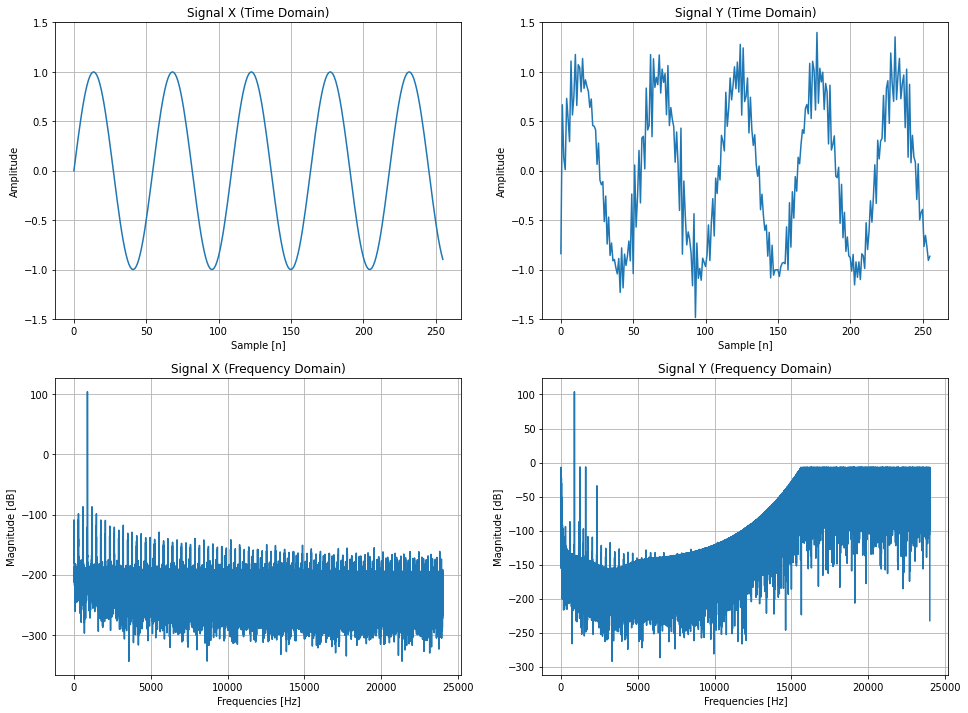

In [6]:
# Plot Signals in Time and Frequency
plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)
plt.plot(x.detach()[:256])
plt.ylim([-1.5,1.5])
plt.title("Signal X (Time Domain)")
plt.xlabel("Sample [n]")
plt.ylabel("Amplitude")
plt.grid()
plt.subplot(2, 2, 2)
plt.plot(y.detach()[:256])
plt.ylim([-1.5,1.5])
plt.title("Signal Y (Time Domain)")
plt.xlabel("Sample [n]")
plt.ylabel("Amplitude")
plt.grid()
plt.subplot(2, 2, 3)
plt.plot(freqs, x_fft_mag)
plt.title('Signal X (Frequency Domain)')
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.subplot(2, 2, 4)
plt.plot(freqs, y_fft_mag)
plt.title('Signal Y (Frequency Domain)')
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

Now it becomes easy to see that the two signals are visualy very different to each other. Signal X seems to be a pure sinusoidal and Signal Y seems to have the same fundamental frequency as Signal Y, some other frequency components close to the fundamental frequency and some noise looking like components very prominent in the high frequencies.

What happens is that Signal Y was carefully designed to sound similar to Signal X by using some well known psychoacoustic characteristics of our hearing system. Even thouhg the signals look like very different to each other both in time and in time-frequency domain, their MSE value has some considerable deviation from zero, they still sound very similar to each other, I would even consider them almost perceptually identical. 

We can make use of some psychoacoustic effects such as frequency masking and the threshold of hearing to design a 'psychoacoustic filter' that would filter out components of our signals that are not actually heard. 

The next step of our investigation is to apply this "psychoacoustic filter" to both signals X and Y and then to calculate the MSE between the filterred versions of our signals, and let's call this loss as Psychoacoustice MSE Loss.

In [7]:
# Compute Psychoacoustic MSE Loss
mse_psychoLoss = PsychoAcousticLoss(mode="mse_time")
mse_psycho = mse_psychoLoss(x,y)

# Compare MSE with Psychoacoustic MSE
print('MSE Loss', mse)
print('MSE Psychoascoutic Loss:', mse_psycho)
print('Losses Rastio:', mse/mse_psycho)

MSE Loss tensor(0.0598)
MSE Psychoascoutic Loss: tensor(0.0003)
Losses Rastio: tensor(224.0730)


/content/psychoacousticLoss.py:216: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:977.)
  return_complex=self.return_complex)


The Psychoacoustic MSE Loss is now much closer to zero than the MSE loss we calculated before. In fact it is more than 200 times smaller than the 'traditional' MSE loss in this situation.

We can say that now some perceptual characteristis of our hearing system are being taken into consideration by this loss function to calculate a 'perceived hearing difference' between the signals.

So far we analysed some very simple audio signals, and just used the MSE loss function. 

Let's now move on to more sophisticated signals, such as music excerpts, and apply the same principles to different loss functions such as the Log Spectral Distance and the Multi Scale Spectral Loss.

For our next experiment, we will use 3 versions of the same music audio signal: a 16-bit PCM .wav file sampled at 44.1kHz, then we will encode this signal into an .mp3 128kbps file and finally we will encoded it also as an .aac file.

We can load these files and listen to them.

In [8]:
print('Example Signal .wav')
display(ipd.Audio(audio_wav.detach(),rate=44100))
print('Example Signal .mp3')
display(ipd.Audio(audio_mp3.detach(),rate=44100))
print('Example Signal .aac')
display(ipd.Audio(audio_aac.detach(),rate=44100))

Example Signal .wav


Example Signal .mp3


Example Signal .aac


All the used codecs are quite popular and it can be very tricky for a non-trained ear to distinguish between all the audio files.

Like we did before, let's calculate both the MSE value and the Psychoacoustic MSE value between the original .wav file and the encoded versions.

In [9]:
# Loss functions
loss_mse = torch.nn.MSELoss()
mse_psychoLoss = PsychoAcousticLoss(mode="mse_time")
mse_wav_aac = loss_mse(audio_aac,audio_wav)
print("MSE Loss (wav_aac):",mse_wav_aac)
mse_psycho_wav_aac = mse_psychoLoss(audio_aac,audio_wav)
print("MSE Psychoacoustic Loss (wav_aac):",mse_psycho_wav_aac)
print("Losses Ratio (wav_aac):",mse_wav_aac/mse_psycho_wav_aac)
mse_wav_mp3 = loss_mse(audio_mp3,audio_wav)
print("MSE Loss (wav_mp3):",mse_wav_mp3)
mse_psycho_wav_mp3 = mse_psychoLoss(audio_mp3,audio_wav)
print("MSE Psychoacoustic Loss (wav_mp3):",mse_psycho_wav_mp3)
print("Losses Ratio (wav_mp3):",mse_wav_mp3/mse_psycho_wav_mp3)

MSE Loss (wav_aac): tensor(0.0758, grad_fn=<MseLossBackward0>)
MSE Psychoacoustic Loss (wav_aac): tensor(0.0007, grad_fn=<MseLossBackward0>)
Losses Ratio (wav_aac): tensor(113.8484, grad_fn=<DivBackward0>)
MSE Loss (wav_mp3): tensor(0.0682, grad_fn=<MseLossBackward0>)
MSE Psychoacoustic Loss (wav_mp3): tensor(0.0007, grad_fn=<MseLossBackward0>)
Losses Ratio (wav_mp3): tensor(91.8890, grad_fn=<DivBackward0>)


Again we notice that the Psychoacoustic Loss function is much smaller than its non-psychoacoustic version, somewhere near the order of magnitude of 100 times smaller.

Let's repeat the same procedure but now we will use the Log Spectral Distance (LSD) loss.

In [10]:
loss_lsd = LSDLoss()
lsd_psychoLoss = PsychoAcousticLoss(mode="lsd")
lsd_wav_aac = loss_lsd(audio_aac,audio_wav)
print("LSD Loss (wav_aac):",lsd_wav_aac)
lsd_psycho_wav_aac = lsd_psychoLoss(audio_aac,audio_wav)
print("LSD Psychoacoustic Loss (wav_aac):",lsd_psycho_wav_aac)
print("Losses Ratio (wav_aac):",lsd_wav_aac/lsd_psycho_wav_aac)
lsd_wav_mp3 = loss_lsd(audio_mp3,audio_wav)
print("LSD Loss (wav_mp3):",lsd_wav_mp3)
lsd_psycho_wav_mp3 = lsd_psychoLoss(audio_mp3,audio_wav)
print("LSD Psychoacoustic Loss (wav_mp3):",lsd_psycho_wav_mp3)
print("Losses Ratio (wav_mp3):",lsd_wav_mp3/lsd_psycho_wav_mp3)


LSD Loss (wav_aac): tensor(1.0500, grad_fn=<MeanBackward1>)
LSD Psychoacoustic Loss (wav_aac): tensor(0.8298, grad_fn=<MeanBackward1>)
Losses Ratio (wav_aac): tensor(1.2653, grad_fn=<DivBackward0>)
LSD Loss (wav_mp3): tensor(0.9811, grad_fn=<MeanBackward1>)
LSD Psychoacoustic Loss (wav_mp3): tensor(0.8129, grad_fn=<MeanBackward1>)
Losses Ratio (wav_mp3): tensor(1.2069, grad_fn=<DivBackward0>)


This time we notice something different. The Psychoacoustic Loss is still smaller than the pure LSD but the difference is much smaller, just around 1.2 times smaller.

Finally we will inspect one more loss function, the Multi Scale Spectral Loss.

In [11]:
loss_multiScaleSpectral = SingleSrcMultiScaleSpectral()
multiscalespectral_psychoLoss = PsychoAcousticLoss(mode="multiscale")
multispectral_wav_aac = loss_multiScaleSpectral(audio_aac.unsqueeze(dim=0),audio_wav.unsqueeze(dim=0))
print("MultiScale Spectral Loss (wav_aac):",multispectral_wav_aac)
multispectral_psycho_wav_aac = multiscalespectral_psychoLoss(audio_aac,audio_wav)
print("Psychoacoustic MultiScale Spectral Loss (wav_aac):",multispectral_psycho_wav_aac)
print("Losses Ratio (wav_aac):",multispectral_wav_aac/multispectral_psycho_wav_aac)
multispectral_wav_mp3 = loss_multiScaleSpectral(audio_mp3.unsqueeze(dim=0),audio_wav.unsqueeze(dim=0))
print("MultiScale Spectral Loss (wav_mp3):",multispectral_wav_mp3)
multispectral_psycho_wav_mp3 = multiscalespectral_psychoLoss(audio_mp3,audio_wav)
print("Psychoacoustic MultiScale Spectral Loss (wav_mp3):",multispectral_psycho_wav_mp3)
print("Losses Ratio (wav_mp3):",multispectral_wav_mp3/multispectral_psycho_wav_mp3)



MultiScale Spectral Loss (wav_aac): tensor([8077451.], grad_fn=<AddBackward0>)
Psychoacoustic MultiScale Spectral Loss (wav_aac): tensor([4455584.], grad_fn=<AddBackward0>)
Losses Ratio (wav_aac): tensor([1.8129], grad_fn=<DivBackward0>)
MultiScale Spectral Loss (wav_mp3): tensor([7990717.5000], grad_fn=<AddBackward0>)
Psychoacoustic MultiScale Spectral Loss (wav_mp3): tensor([4386523.5000], grad_fn=<AddBackward0>)
Losses Ratio (wav_mp3): tensor([1.8217], grad_fn=<DivBackward0>)


Again we notice something similar to what we've seen with the previous loss. The psychoacoustic version of the loss is still smaller, but only around 1.8 times smaller.

Once again we can plot the signals in time and in time-frequency domain for a visual inspection.

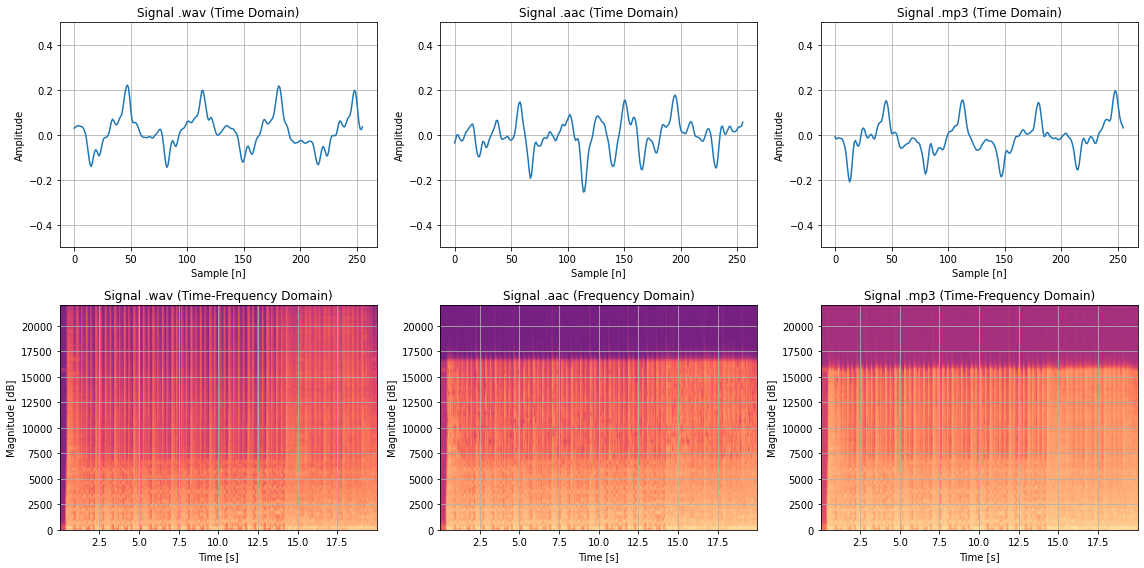

In [12]:
plt.figure(figsize=(16,8))
plt.subplot(2, 3, 1)
plt.plot(audio_wav.detach()[200000:200256])
plt.ylim([-0.5,0.5])
plt.title("Signal .wav (Time Domain)")
plt.xlabel("Sample [n]")
plt.ylabel("Amplitude")
plt.grid()
plt.subplot(2, 3, 2)
plt.plot(audio_aac.detach()[200000:200256])
plt.ylim([-0.5,0.5])
plt.title("Signal .aac (Time Domain)")
plt.xlabel("Sample [n]")
plt.ylabel("Amplitude")
plt.grid()
plt.subplot(2, 3, 3)
plt.plot(audio_mp3.detach()[200000:200256])
plt.ylim([-0.5,0.5])
plt.title("Signal .mp3 (Time Domain)")
plt.xlabel("Sample [n]")
plt.ylabel("Amplitude")
plt.grid()
plt.subplot(2, 3, 4)
plt.specgram(audio_wav.detach().numpy(), Fs=44100, cmap='magma')
plt.title("Signal .wav (Time-Frequency Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Magnitude [dB]")
plt.grid()
plt.subplot(2, 3, 5)
plt.specgram(audio_aac.detach().numpy(), Fs=44100, cmap='magma')
plt.title("Signal .aac (Frequency Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Magnitude [dB]")
plt.grid()
plt.subplot(2, 3, 6)
plt.specgram(audio_mp3.detach().numpy(), Fs=44100, cmap='magma')
plt.title("Signal .mp3 (Time-Frequency Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Magnitude [dB]")
plt.grid()
plt.tight_layout()


The visual difference is again very noticeable both in time and in time-frequency domain.